In [342]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from datetime import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from imblearn.over_sampling import RandomOverSampler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackerearth-ml-challenge-pet-adoption/test.csv
/kaggle/input/hackerearth-ml-challenge-pet-adoption/train.csv


In [343]:
from fastai.tabular import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [344]:
train_df = pd.read_csv("../input/hackerearth-ml-challenge-pet-adoption/train.csv")
test_df = pd.read_csv("../input/hackerearth-ml-challenge-pet-adoption/test.csv")

test_id = test_df['pet_id']
test_df.shape

(8072, 9)

In [345]:
#Check Missing Values
percent_missing = train_df.isnull().sum() * 100 / len(train_df)
missing_value_df = pd.DataFrame({'column_name': train_df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
pet_id,pet_id,0.0000
issue_date,issue_date,0.0000
listing_date,listing_date,0.0000
color_type,color_type,0.0000
length(m),length(m),0.0000
height(cm),height(cm),0.0000
X1,X1,0.0000
X2,X2,0.0000
breed_category,breed_category,0.0000
pet_category,pet_category,0.0000


In [346]:
train_df.condition.value_counts()

1.0    6819
0.0    6281
2.0    4257
Name: condition, dtype: int64

In [347]:
#Assig Missing COndition as Miss

train_df['condition'].fillna(-1,inplace=True)
test_df['condition'].fillna(-1,inplace=True)

In [348]:
train_df['breed_category'] = train_df['breed_category'].astype('int64')
train_df['condition'] = train_df['condition'].astype('int64',errors = 'ignore')
train_df['breed_category'] = train_df['breed_category'].astype('category',copy=False)
train_df['pet_category'] = train_df['pet_category'].astype('category',copy=False)
train_df['condition'] = train_df['condition'].astype('category',copy=False)
train_df['color_type'] = train_df['color_type'].astype('category',copy=False)

In [349]:
#train_df.condition.fillna(99, inplace=True) #Need to generate this base on EDA
#train_df['condition'] = train_df['condition'].fillna(train_df['condition'].mode()[0]) #Maybe use knn

In [350]:

train_df['listing_date'] = train_df['listing_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train_df['issue_date'] = train_df['issue_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
min_date = min(train_df['issue_date'])

train_df["Age"]=(train_df['issue_date'] - min_date).dt.days

train_df['list_dur']  = (train_df['listing_date'] -train_df['issue_date']).dt.days

train_df.head(2)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category,Age,list_dur
0,ANSL_69903,2016-07-10,2016-09-21 16:25:00,2,Brown Tabby,0.80,7.78,13,9,0,1,7870,73
1,ANSL_66892,2013-11-21,2018-12-27 17:47:00,1,White,0.72,14.19,13,9,0,2,6908,1862


In [351]:
test_df['listing_date'] = test_df['listing_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test_df['issue_date'] = test_df['issue_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

test_df["Age"]=(test_df['issue_date'] - min_date).dt.days

test_df['list_dur']  = (test_df['listing_date'] -test_df['issue_date']).dt.days

test_df.head(2)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,Age,list_dur
0,ANSL_75005,2005-08-17,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7,3890,4404
1,ANSL_76663,2018-11-15,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1,8728,174


In [352]:
#Get overall sense of data
train_df.describe()

,length(m),height(cm),X1,X2,Age,list_dur
count,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000
mean,0.502636,27.448832,5.369598,4.577307,7534.747531,855.306786
std,0.288705,13.019781,6.572366,3.517763,1132.397378,1096.674990
min,0.000000,5.000000,0.000000,0.000000,0.000000,-76.000000
25%,0.250000,16.172500,0.000000,1.000000,7261.000000,119.000000
50%,0.500000,27.340000,0.000000,4.000000,7884.000000,392.000000
75%,0.760000,38.890000,13.000000,9.000000,8237.000000,1117.000000
max,1.000000,50.000000,19.000000,9.000000,8850.000000,8056.000000


In [353]:
train_df.drop(train_df[train_df['list_dur'] <= 0].index, inplace = True) 

In [354]:
train_df.dtypes

pet_id                    object
issue_date        datetime64[ns]
listing_date      datetime64[ns]
condition               category
color_type              category
length(m)                float64
height(cm)               float64
X1                         int64
X2                         int64
breed_category          category
pet_category            category
Age                        int64
list_dur                   int64
dtype: object

In [355]:
train_df.breed_category.value_counts()/train_df.shape[0]

0    0.477857
1    0.443713
2    0.078430
Name: breed_category, dtype: float64

In [356]:
#Create additonal features using the date given
add_datepart(train_df, "issue_date", drop=False)
add_datepart(train_df, "listing_date", drop=False)

#Create additonal features using the date given
add_datepart(test_df, "issue_date", drop=False)
add_datepart(test_df, "listing_date", drop=False)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,...,issue_Day,issue_Dayofweek,issue_Dayofyear,issue_Is_month_end,issue_Is_month_start,issue_Is_quarter_end,issue_Is_quarter_start,issue_Is_year_end,issue_Is_year_start,issue_Elapsed
0,ANSL_69903,2016-07-10,2016-09-21 16:25:00,2,Brown Tabby,0.80,7.78,13,9,0,...,10,6,192,False,False,False,False,False,False,1468108800
1,ANSL_66892,2013-11-21,2018-12-27 17:47:00,1,White,0.72,14.19,13,9,0,...,21,3,325,False,False,False,False,False,False,1384992000
2,ANSL_69750,2014-09-28,2016-10-19 08:24:00,-1,Brown,0.15,40.90,15,4,2,...,28,6,271,False,False,False,False,False,False,1411862400
3,ANSL_71623,2016-12-31,2019-01-25 18:30:00,1,White,0.62,17.82,0,1,0,...,31,5,366,True,False,True,False,True,False,1483142400
4,ANSL_57969,2017-09-28,2017-11-19 09:38:00,2,Black,0.50,11.06,18,4,0,...,28,3,271,False,False,False,False,False,False,1506556800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18829,ANSL_51738,2017-01-26,2018-03-09 15:35:00,2,Tricolor,0.44,27.36,0,1,0,...,26,3,26,False,False,False,False,False,False,1485388800
18830,ANSL_59900,2016-06-18,2017-07-09 08:37:00,-1,Brown,0.73,14.25,15,4,2,...,18,5,170,False,False,False,False,False,False,1466208000
18831,ANSL_53210,2010-07-21,2018-08-22 14:27:00,0,Calico Point,0.99,28.13,13,9,1,...,21,2,202,False,False,False,False,False,False,1279670400
18832,ANSL_63468,2017-05-12,2018-02-08 14:05:00,0,Tan,0.55,44.82,13,9,1,...,12,4,132,False,False,False,False,False,False,1494547200


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,...,listing_Day,listing_Dayofweek,listing_Dayofyear,listing_Is_month_end,listing_Is_month_start,listing_Is_quarter_end,listing_Is_quarter_start,listing_Is_year_end,listing_Is_year_start,listing_Elapsed
0,ANSL_69903,2016-07-10,2016-09-21 16:25:00,2,Brown Tabby,0.80,7.78,13,9,0,...,21,2,265,False,False,False,False,False,False,1474475100
1,ANSL_66892,2013-11-21,2018-12-27 17:47:00,1,White,0.72,14.19,13,9,0,...,27,3,361,False,False,False,False,False,False,1545932820
2,ANSL_69750,2014-09-28,2016-10-19 08:24:00,-1,Brown,0.15,40.90,15,4,2,...,19,2,293,False,False,False,False,False,False,1476865440
3,ANSL_71623,2016-12-31,2019-01-25 18:30:00,1,White,0.62,17.82,0,1,0,...,25,4,25,False,False,False,False,False,False,1548441000
4,ANSL_57969,2017-09-28,2017-11-19 09:38:00,2,Black,0.50,11.06,18,4,0,...,19,6,323,False,False,False,False,False,False,1511084280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18829,ANSL_51738,2017-01-26,2018-03-09 15:35:00,2,Tricolor,0.44,27.36,0,1,0,...,9,4,68,False,False,False,False,False,False,1520609700
18830,ANSL_59900,2016-06-18,2017-07-09 08:37:00,-1,Brown,0.73,14.25,15,4,2,...,9,6,190,False,False,False,False,False,False,1499589420
18831,ANSL_53210,2010-07-21,2018-08-22 14:27:00,0,Calico Point,0.99,28.13,13,9,1,...,22,2,234,False,False,False,False,False,False,1534948020
18832,ANSL_63468,2017-05-12,2018-02-08 14:05:00,0,Tan,0.55,44.82,13,9,1,...,8,3,39,False,False,False,False,False,False,1518098700


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,Age,...,issue_Day,issue_Dayofweek,issue_Dayofyear,issue_Is_month_end,issue_Is_month_start,issue_Is_quarter_end,issue_Is_quarter_start,issue_Is_year_end,issue_Is_year_start,issue_Elapsed
0,ANSL_75005,2005-08-17,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7,3890,...,17,2,229,False,False,False,False,False,False,1124236800
1,ANSL_76663,2018-11-15,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1,8728,...,15,3,319,False,False,False,False,False,False,1542240000
2,ANSL_58259,2012-10-11,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7,6502,...,11,3,285,False,False,False,False,False,False,1349913600
3,ANSL_67171,2015-02-13,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1,7357,...,13,4,44,False,False,False,False,False,False,1423785600
4,ANSL_72871,2017-01-18,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7,8062,...,18,2,18,False,False,False,False,False,False,1484697600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8067,ANSL_66809,2016-02-10,2017-03-10 14:56:00,2.0,Brown,0.82,36.08,13,9,7719,...,10,2,41,False,False,False,False,False,False,1455062400
8068,ANSL_59041,2015-12-07,2018-02-12 00:00:00,0.0,Tan,0.49,27.54,13,9,7654,...,7,0,341,False,False,False,False,False,False,1449446400
8069,ANSL_60034,2015-12-08,2017-01-04 17:19:00,0.0,Black,0.98,37.19,0,7,7655,...,8,1,342,False,False,False,False,False,False,1449532800
8070,ANSL_58066,2016-06-28,2017-07-20 18:19:00,-1.0,Black,0.79,23.83,0,2,7858,...,28,1,180,False,False,False,False,False,False,1467072000


,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,Age,...,listing_Day,listing_Dayofweek,listing_Dayofyear,listing_Is_month_end,listing_Is_month_start,listing_Is_quarter_end,listing_Is_quarter_start,listing_Is_year_end,listing_Is_year_start,listing_Elapsed
0,ANSL_75005,2005-08-17,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7,3890,...,7,3,250,False,False,False,False,False,False,1504798500
1,ANSL_76663,2018-11-15,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1,8728,...,8,2,128,False,False,False,False,False,False,1557336240
2,ANSL_58259,2012-10-11,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7,6502,...,2,0,92,False,False,False,False,False,False,1522687860
3,ANSL_67171,2015-02-13,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1,7357,...,6,4,96,False,False,False,False,False,False,1522999500
4,ANSL_72871,2017-01-18,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7,8062,...,26,3,116,False,False,False,False,False,False,1524750120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8067,ANSL_66809,2016-02-10,2017-03-10 14:56:00,2.0,Brown,0.82,36.08,13,9,7719,...,10,4,69,False,False,False,False,False,False,1489157760
8068,ANSL_59041,2015-12-07,2018-02-12 00:00:00,0.0,Tan,0.49,27.54,13,9,7654,...,12,0,43,False,False,False,False,False,False,1518393600
8069,ANSL_60034,2015-12-08,2017-01-04 17:19:00,0.0,Black,0.98,37.19,0,7,7655,...,4,2,4,False,False,False,False,False,False,1483550340
8070,ANSL_58066,2016-06-28,2017-07-20 18:19:00,-1.0,Black,0.79,23.83,0,2,7858,...,20,3,201,False,False,False,False,False,False,1500574740


In [357]:
train_df=train_df.drop(['issue_Year','issue_Week','issue_Day','issue_Dayofyear','issue_Is_month_end', 'issue_Day',
                        'issue_Dayofyear', 'issue_Is_month_end',
        'issue_Is_quarter_end', 'issue_Is_quarter_start', 'issue_Is_year_end',
       'issue_Elapsed', 'listing_Year', 'listing_Week', 'listing_Dayofyear',
       'listing_Is_month_end', 
       'listing_Is_quarter_end', 'listing_Is_quarter_start',
       'listing_Is_year_end', 'listing_Elapsed',
       'listing_Day'  ], axis = 1) 

test_df=test_df.drop(['issue_Year','issue_Week','issue_Day','issue_Dayofyear','issue_Is_month_end', 'issue_Day',
                        'issue_Dayofyear', 'issue_Is_month_end',
        'issue_Is_quarter_end', 'issue_Is_quarter_start', 'issue_Is_year_end',
       'issue_Elapsed', 'listing_Year', 'listing_Week', 'listing_Dayofyear',
       'listing_Is_month_end', 
       'listing_Is_quarter_end', 'listing_Is_quarter_start',
       'listing_Is_year_end', 'listing_Elapsed',
       'listing_Day'  ], axis = 1) 

In [358]:
#Create a copy for Random Forest
train_df1 = train_df.copy(deep=True)

y_train1= train_df1.breed_category
train_df1= train_df1.drop(['breed_category','pet_category','pet_id','issue_date','listing_date'], axis = 1) 

In [359]:
os=RandomOverSampler()
X_train_ns,y_train_ns=os.fit_sample(train_df1,y_train1)
print("The number of classes before fit {}".format(Counter(y_train1)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({0: 8999, 1: 8356, 2: 1477})
The number of classes after fit Counter({0: 8999, 2: 8999, 1: 8999})


In [360]:
#### Train Test Split

X_train,X_test,y_train,y_test=train_test_split(X_train_ns,y_train_ns,test_size=0.20,random_state=0,stratify = y_train_ns)

In [318]:
# One-hot encode the data using pandas get_dummies
X_train = pd.get_dummies( X_train)
X_test = pd.get_dummies( X_test)


In [273]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

In [274]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)
rf_randomcv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 25.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 340,
 'criterion': 'entropy'}

In [276]:
best_random_grid=rf_randomcv.best_estimator_
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[1632  168    0]
 [ 202 1598    0]
 [   0    0 1800]]
Accuracy Score 0.9314814814814815
Classification report:               precision    recall  f1-score   support

           0       0.89      0.91      0.90      1800
           1       0.90      0.89      0.90      1800
           2       1.00      1.00      1.00      1800

    accuracy                           0.93      5400
   macro avg       0.93      0.93      0.93      5400
weighted avg       0.93      0.93      0.93      5400



In [ ]:
################### Testing with Tabular Deep Learnaning ##########################

In [361]:
deep_df= pd.concat([X_train_ns,y_train_ns], axis=1)
deep_df.columns

Index(['condition', 'color_type', 'length(m)', 'height(cm)', 'X1', 'X2', 'Age',
       'list_dur', 'issue_Month', 'issue_Dayofweek', 'issue_Is_month_start',
       'issue_Is_year_start', 'listing_Month', 'listing_Dayofweek',
       'listing_Is_month_start', 'listing_Is_year_start', 'breed_category'],
      dtype='object')

In [362]:
# Define the Columns for the Tabular Learner
dep_var = 'breed_category' #target
cat_names = ['condition', 'color_type','issue_Is_year_start','listing_Is_year_start','listing_Month','listing_Dayofweek','issue_Month','issue_Dayofweek','issue_Is_month_start', 'listing_Is_month_start']
cont_names = ['length(m)', 'height(cm)','X1','X2','Age', 'list_dur']
procs = [FillMissing, Categorify, Normalize]

In [363]:
# Creation of the Data for the Tabular learner
test = TabularList.from_df(test_df, 
                           cat_names=cat_names, 
                           cont_names=cont_names, procs=procs)

data = (TabularList.from_df(deep_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(0.20,seed=123) # .split_none()
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=2048))

In [364]:
data.c

3

In [365]:
#Display the data batch
data.show_batch(rows = 3)

condition,color_type,issue_Is_year_start,listing_Is_year_start,listing_Month,listing_Dayofweek,issue_Month,issue_Dayofweek,issue_Is_month_start,listing_Is_month_start,length(m),height(cm),X1,X2,Age,list_dur,target
-1,Brown,False,False,3,5,3,3,False,False,0.4763,0.4148,1.0697,-0.2842,-0.2634,0.3945,2
1,Brown Tabby,False,False,4,6,3,2,False,False,-0.5596,-0.1069,-1.0778,0.9107,-0.6175,1.1474,0
1,Blue Tick,False,False,4,1,9,4,False,False,-1.0085,0.3569,-1.0778,-1.1803,0.6339,-0.5158,0


In [366]:
#Initializing the Model
learn = tabular_learner(data,layers=[500,400, 200, 100], metrics=accuracy, emb_drop=0.1,callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 7.59E-02


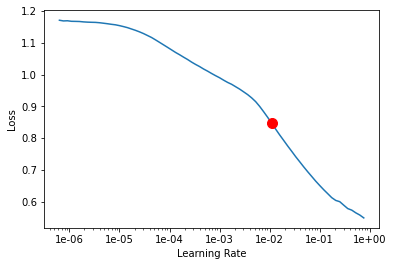

In [367]:
#Exploring the learning rates
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.868200,0.807102,0.602334,00:01
1,0.618119,0.833751,0.752362,00:01
2,0.429505,1.784916,0.734210,00:01
3,0.336592,0.202237,0.919800,00:01
4,0.273954,0.141464,0.921467,00:01
5,0.231380,0.114550,0.922763,00:01
6,0.202515,0.111459,0.926097,00:01
7,0.180630,0.112128,0.927579,00:01
8,0.163872,0.114319,0.925357,00:01
9,0.151035,0.112858,0.924245,00:01


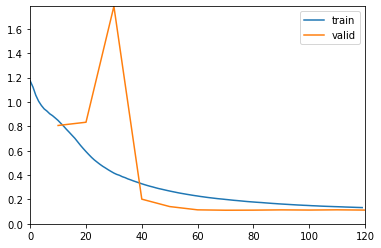

In [368]:
lr =7e-2
mod_name="stage1"
# smaller rate with smaller steps
learn.fit_one_cycle(12, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.100323,0.116895,0.929246,00:01
1,0.111949,0.115148,0.919615,00:01
2,0.112796,0.113887,0.928690,00:01
3,0.109238,0.111490,0.930728,00:01


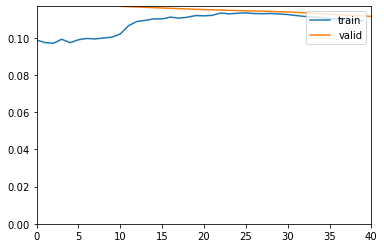

epoch,train_loss,valid_loss,accuracy,time
0,0.100954,0.111163,0.930357,00:01
1,0.101799,0.112166,0.930357,00:01
2,0.101100,0.113359,0.928690,00:01
3,0.100702,0.112973,0.931469,00:02
4,0.099978,0.112988,0.931098,00:01
5,0.099750,0.113244,0.929802,00:01


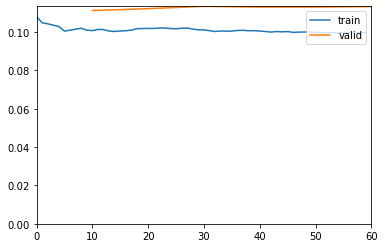

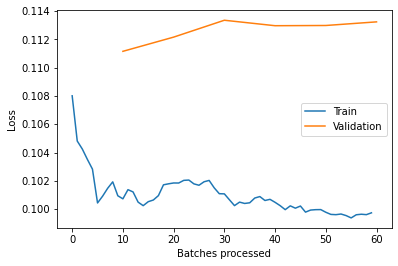

In [369]:
#  higher learn-rate 
learn.fit_one_cycle(4, lr)

# smaller rate 
learn.fit_one_cycle(6, lr/20)

# plot losses
learn.recorder.plot_losses()

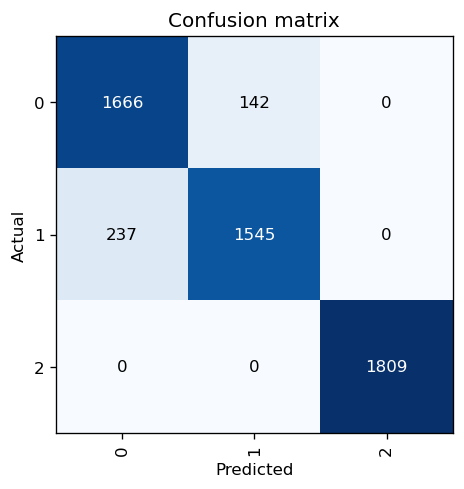

In [370]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=120)

In [371]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels]

# create submission file to submit in Kaggle competition
submission = pd.DataFrame({'pet_id': test_id, 'breed_category': test_predictions_direct})



In [372]:
#Add new predictions to test
test_new = pd.merge(test_df, submission, on='pet_id')
test_new.head(2)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,Age,list_dur,issue_Month,issue_Dayofweek,issue_Is_month_start,issue_Is_year_start,listing_Month,listing_Dayofweek,listing_Is_month_start,listing_Is_year_start,breed_category
0,ANSL_75005,2005-08-17,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7,3890,4404,8,2,False,False,9,3,False,False,1
1,ANSL_76663,2018-11-15,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1,8728,174,11,3,False,False,5,2,False,False,0


In [373]:
os=RandomOverSampler()
y_train= train_df.pet_category
X_train_nw,y_train_nw=os.fit_sample(train_df.drop(["pet_category"], axis = 1) ,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_nw)))

The number of classes before fit Counter({2: 10621, 1: 7182, 4: 941, 0: 88})
The number of classes after fit Counter({1: 10621, 2: 10621, 4: 10621, 0: 10621})


In [374]:
deep_df_pet= pd.concat([X_train_nw,y_train_nw], axis=1)
deep_df_pet.columns

Index(['pet_id', 'issue_date', 'listing_date', 'condition', 'color_type',
       'length(m)', 'height(cm)', 'X1', 'X2', 'breed_category', 'Age',
       'list_dur', 'issue_Month', 'issue_Dayofweek', 'issue_Is_month_start',
       'issue_Is_year_start', 'listing_Month', 'listing_Dayofweek',
       'listing_Is_month_start', 'listing_Is_year_start', 'pet_category'],
      dtype='object')

In [375]:
dep_var = 'pet_category' #target
cat_names.append('breed_category')

In [376]:

test_new = TabularList.from_df(test_new, 
                           cat_names=cat_names, 
                           cont_names=cont_names, procs=procs)

data = (TabularList.from_df(deep_df_pet, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(0.20,seed=123) # .split_none()
                           .label_from_df(cols=dep_var)
                           .add_test(test_new)
                           .databunch(bs=2048))

#Initializing the Model
learn = tabular_learner(data, layers=[500,400, 200, 100], metrics=accuracy, emb_drop=0.1,callback_fns=ShowGraph)

In [377]:
data.c

4

epoch,train_loss,valid_loss,accuracy,time
0,0.773279,0.952207,0.692208,00:02
1,0.505593,0.771507,0.832274,00:02
2,0.389756,0.265083,0.910782,00:02
3,0.315150,0.218629,0.917373,00:02
4,0.266715,0.189622,0.925024,00:02
5,0.228273,0.136547,0.944091,00:02
6,0.197253,0.130400,0.943738,00:02
7,0.171389,0.118470,0.948564,00:02
8,0.150029,0.113606,0.952448,00:02
9,0.134157,0.110362,0.952684,00:03


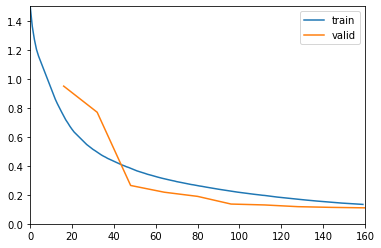

In [378]:
lr =1e-1
mod_name="stage1"
# smaller rate with smaller steps
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.097906,0.146980,0.940678,00:02
1,0.172467,0.365343,0.895598,00:02
2,0.167848,0.143330,0.942443,00:02
3,0.150159,0.119163,0.950918,00:02


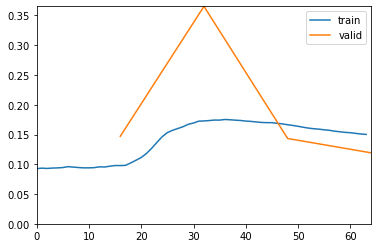

epoch,train_loss,valid_loss,accuracy,time
0,0.114478,0.117067,0.951153,00:02
1,0.111659,0.113552,0.952095,00:02
2,0.109306,0.111819,0.952566,00:02


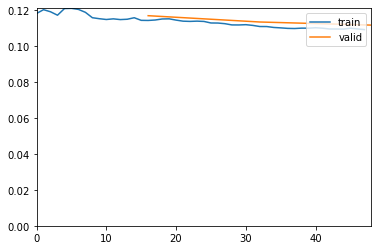

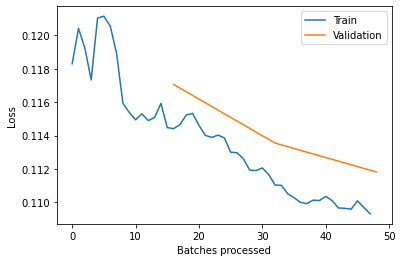

In [379]:
#  higher learn-rate 
learn.fit_one_cycle(4, lr)

# smaller rate 
learn.fit_one_cycle(3, lr/20)

# plot losses
learn.recorder.plot_losses()

In [380]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels]

# create submission file to submit in Kaggle competition
submission_2 = pd.DataFrame({'pet_id': test_id, 'pet_category': test_predictions_direct})

In [381]:
df_final = pd.merge(submission, submission_2, on='pet_id')
df_final['breed_category']= df_final['breed_category'].astype(int)
df_final['pet_category']= df_final['pet_category'].astype(int)
df_final.head(2)

df_final.to_csv('Pet_submission.csv', index=False)

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1


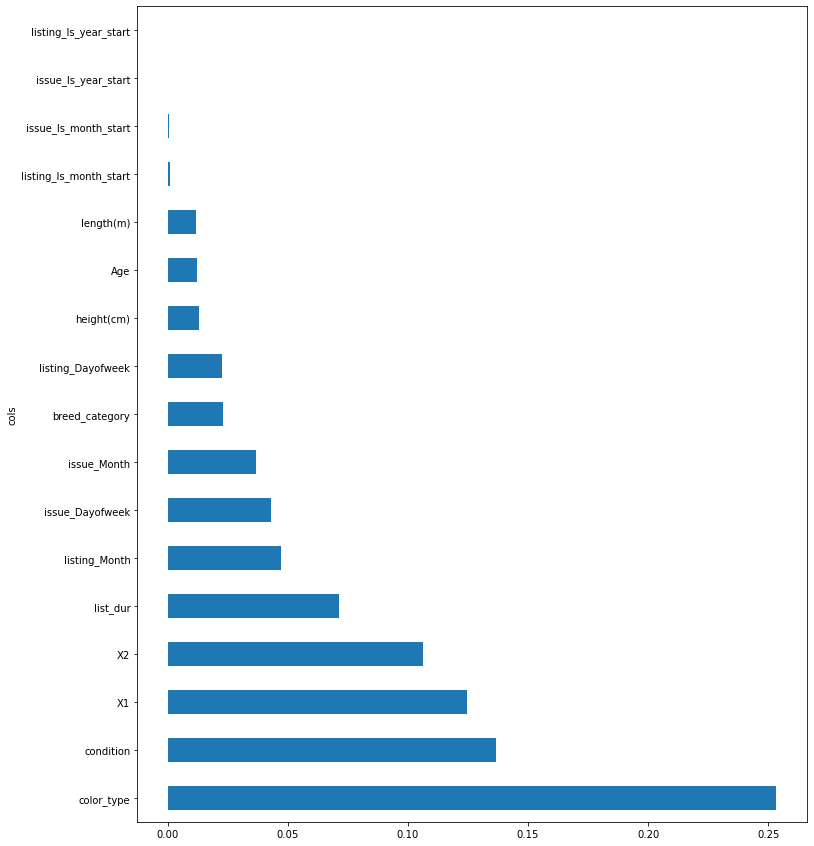

In [382]:

# Assumes all necessary fast.ai v1.0 libraries are loaded

def feature_importance(learner): 
    data = learner.data.train_ds.x
    cat_names = data.cat_names
    cont_names = data.cont_names
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
      for i, c in enumerate(t):
        loss=[]
        for x,y in iter(learner.data.valid_dl):
          col=x[j][:,i]    #x[0] da hier cat-vars
          idx = torch.randperm(col.nelement())
          x[j][:,i] = col.view(-1)[idx].view(col.size())
          y=y.to('cpu')
          loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
        fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})
  
  ## my model is called 'learn'
features = feature_importance(learn)
  
  ## plot 'em!
features.plot('cols', 'imp', 'barh', figsize=(12,15), legend=False)